In [1]:
%matplotlib inline
import numpy as np

import seaborn as sns
import pandas as pd
import rubisco_data

from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Merge multiple measurements of the same organism by taking the median value.
merged_kin_df = rubisco_data.merge_organisms(raw_kin_df)

# Group by RuBisCO form
grouped_form = merged_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)

In [3]:
# Load BRENDA data
brenda_DF = pd.read_csv('../data/DatasetS3_BRENDA_Kinetics.csv', encoding = "ISO-8859-1")
brenda_DF.head(3)

has_kcat = brenda_DF[brenda_DF.kcat.notnull()]
brenda_by_EC = has_kcat.groupby('EC_number')

# median reported kcat
brenda_kcats = brenda_DF.groupby(['EC_number', 'Organism'], as_index=False).median()
# number of measurements
orths = brenda_kcats.groupby('EC_number', as_index=False).size()
orths = pd.DataFrame(orths).reset_index()
orths.columns = ['EC_number', 'n_orthologs']

var_df = brenda_kcats.groupby('EC_number')['kcat'].apply(lambda x: np.exp(np.nanstd(np.log(x))))
sig_star = brenda_kcats.groupby('EC_number')['kcat'].apply(lambda x: np.nanstd(np.log10(x)))

var_df = pd.DataFrame(var_df).reset_index()
var_df = var_df.merge(orths)

var_df.columns = ['EC', 'mult_var', 'n_orthologs']
var_df.sort_values('n_orthologs', inplace=True, ascending=False)
var_df.set_index('EC', inplace=True)
var_df.dropna(inplace=True)
var_df['sigma_star'] = sig_star

# Remove low counts, drop rubisco
filtered_var = var_df[var_df.n_orthologs > 5].copy()
filtered_var = filtered_var.drop('4.1.1.39')

filtered_var.head()

/usr/local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,mult_var,n_orthologs,sigma_star
EC,,,
3.1.3.2,11.720575,47,1.068949
1.1.1.37,70.439630,46,1.847817
2.5.1.18,9.027363,46,0.955561
4.2.1.1,20.112578,45,1.303468
4.1.2.13,6.657846,44,0.823334


In [4]:
rub_has_kcat = merged_kin_df[merged_kin_df.vC.notnull()]
rub_grouped = rub_has_kcat.groupby(['species', 'isoform'], as_index=False)
rub_n_orths = rub_grouped.ngroups
rub_median = rub_grouped.median()

rub_mult_var = np.exp(np.std(np.log(rub_median['vC'])))

In [5]:
var_df.at['4.1.1.39', 'n_orthologs'] = rub_n_orths
var_df.at['4.1.1.39', 'mult_var'] = rub_mult_var
var_df.sort_values('n_orthologs', inplace=True, ascending=False)
var_df.head()

,mult_var,n_orthologs,sigma_star
EC,,,
4.1.1.39,1.520372,248,0.268739
3.1.3.2,11.720575,47,1.068949
1.1.1.37,70.439630,46,1.847817
2.5.1.18,9.027363,46,0.955561
4.2.1.1,20.112578,45,1.303468


In [6]:
top_counts = var_df.iloc[:25].sort_values('mult_var', ascending=True)
brenda_kcats_subset = brenda_kcats[brenda_kcats.EC_number.isin(top_counts.index)].copy()
brenda_kcats_subset = brenda_kcats_subset[brenda_kcats_subset.kcat.notnull()]

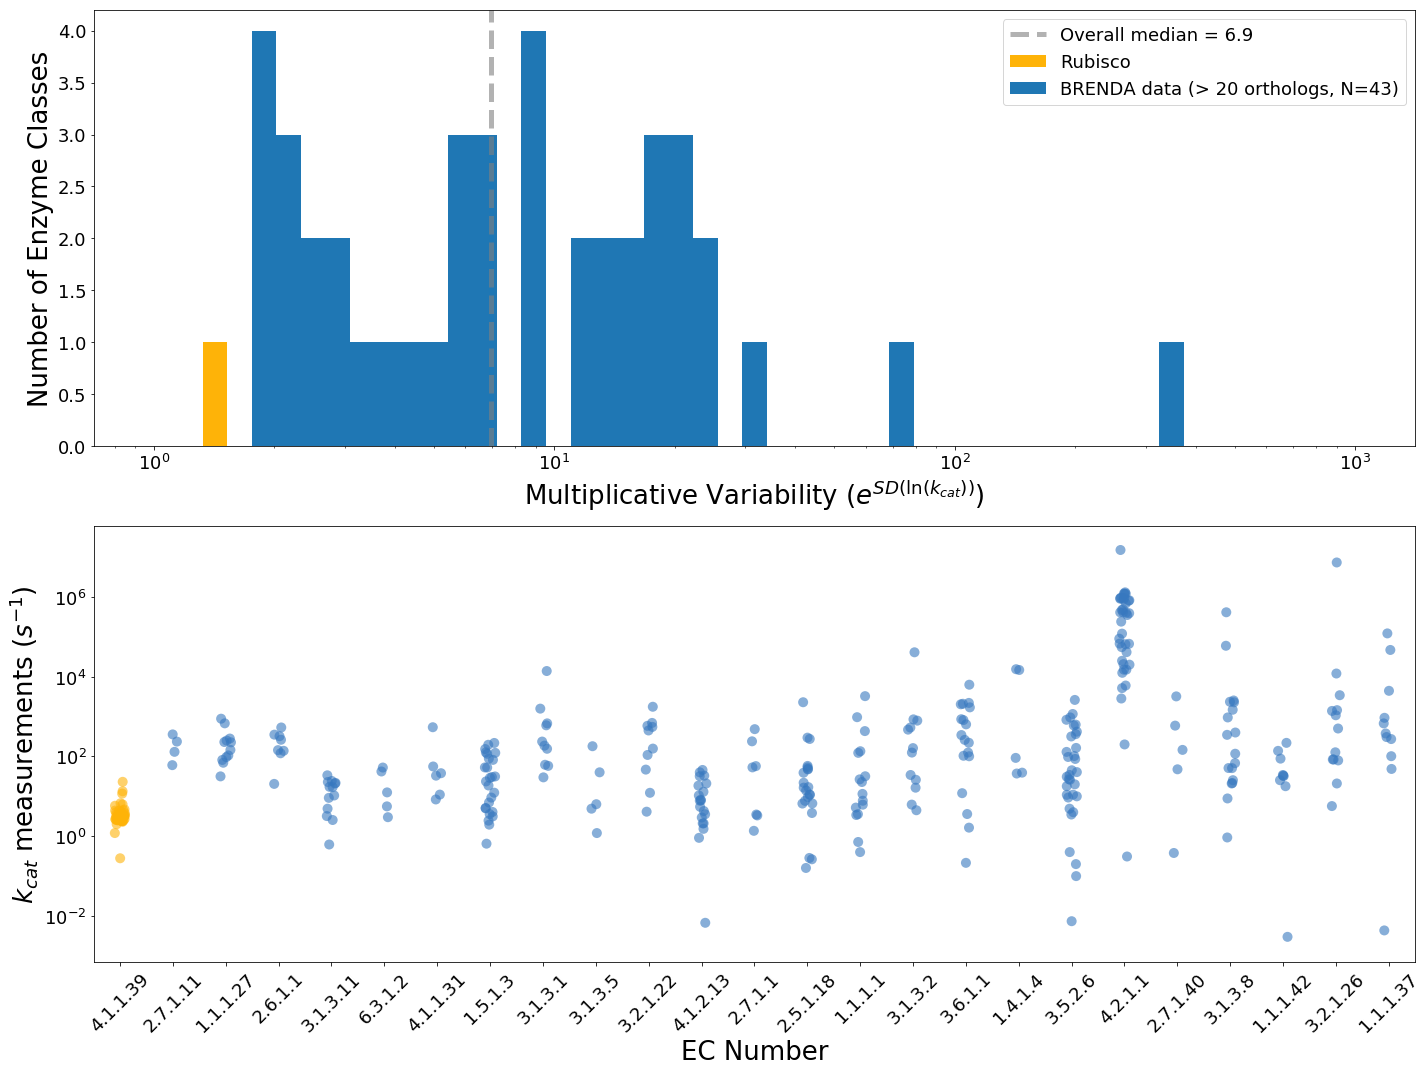

Median multiplicative variability 6.948274986639359


In [7]:
figure = plt.figure(figsize=(20,15))

gs = plt.GridSpec(2, 1)

# Histogram of variabilities
plt.subplot(gs[0])
plt.xscale('log')

bins = np.logspace(0, 3, 50)
enough_reports = var_df[var_df.n_orthologs > 20]
enough_reports_no_rub = enough_reports.drop('4.1.1.39')
plt.hist(enough_reports.mult_var, bins=bins, label='Rubisco', color=named_colors[1])
plt.hist(enough_reports_no_rub.mult_var, bins=bins, label='BRENDA data (> 20 orthologs, N=%d)' % enough_reports.shape[0])
#plt.axvline(rub_mult_var, color=named_colors[1], lw=5, ls='--',
#            label='Rubisco = %.1f' % rub_mult_var, alpha=0.6)
plt.axvline(enough_reports.mult_var.median(), color='grey', lw=5, ls='--',
            label='Overall median = %.1f' % enough_reports.mult_var.median(), alpha=0.6)

plt.legend(loc=1, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel('Multiplicative Variability ($e^{SD(\ln(k_{cat}))}$)', fontsize=26)
plt.ylabel('Number of Enzyme Classes', fontsize=26)

# Top 25 ECs by number of orthologs
ax = plt.subplot(gs[1])

plt.yscale('log')
palette = [named_colors[1]] + [named_colors[0]] * 24
sns.stripplot(x='EC_number', y='kcat', order=top_counts.index, data=brenda_kcats_subset,
              jitter=0.1, palette=palette, size=10, alpha=0.6)
plt.xticks(fontsize=18, ha='center', rotation=45)
plt.yticks(fontsize=18)

plt.xlabel('EC Number', fontsize=26)
plt.ylabel('$k_{cat}$ measurements ($s^{-1}$)', fontsize=26)

plt.tight_layout()
plt.show()

print('Median multiplicative variability', enough_reports.mult_var.median())

In [8]:
enough_reports.sort_values('mult_var', ascending=False).head()

,mult_var,n_orthologs,sigma_star
EC,,,
4.6.1.1,367.131841,22,2.564822
1.1.1.37,70.439630,46,1.847817
3.2.1.26,29.685504,40,1.472544
1.1.1.42,23.548667,33,1.371966
2.7.4.3,22.714042,22,1.356294


In [9]:
conf_range = [2.5, 97.5]

all_interval = np.percentile(enough_reports.mult_var, conf_range)
median_var = enough_reports.mult_var.median()

print('95% CI', np.log(all_interval))
print('median', np.log(median_var))
print()

95% CI [0.57338607 4.22540095]
median 1.9384934254079054



In [10]:
# What fraction of kcat,C values are between 1.0 and 10.0? ~97%
mask = np.logical_and(rub_has_kcat.vC >= 1.0, rub_has_kcat.vC <= 10.0)
in_range = rub_has_kcat[mask].shape[0]
total = rub_has_kcat.vC.notnull().sum()
print(float(in_range)/float(total))

0.9718875502008032


In [11]:
conf_range = [2.5, 97.5]

print(np.percentile(enough_reports.sigma_star, conf_range))
print(np.nanmedian(enough_reports.sigma_star))

[0.2572741  1.82905343]
0.8418769978603863
